# Simple Sound Event Detection (SED) using Max Min filter 

In [17]:
# packages
## system
import os, warnings, sys, pathlib
from pathlib import Path
warnings.filterwarnings('ignore')

## data structure
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import tensorflow.keras.backend as K
from tensorflow.python.keras.utils.data_utils import Sequence

## utils
import math
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import random
import datetime
import time
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
import shutil

## image 
# import cv2
from PIL import Image
# from skimage.transform import rotate
# import imgaug.augmenters as iaa

## audio
import soundfile as sf
import librosa
# from pydub import AudioSegment

## data cleaning
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, OneHotEncoder, scale
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

## graphing
import librosa.display
# import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:
# print(tf.test.is_gpu_available(), tf.config.list_physical_devices('GPU'))

# traning encoder

## training data path

In [4]:
# get image path
# define audio dataset path

DATASET_AUDIO = "train_audio/"
DATASET_SPEC = "../applications/data/TUT-sound-events-2017-development/audio/street"

print(DATASET_SPEC)


../applications/data/TUT-sound-events-2017-development/audio/street


## lable encoder 

In [5]:
# get index of label and freq 
label_names = sorted(set(os.listdir(DATASET_SPEC)))

# onehot encode label and freq
label_to_onehot = OneHotEncoder(sparse = False)
label_to_onehot.fit(np.array(label_names).reshape(-1, 1))
label_dict = dict(zip(label_names, label_to_onehot.fit_transform(np.array(label_names).reshape(-1, 1))))


In [6]:
pd.DataFrame(label_dict)

,a001.wav,a003.wav,a008.wav,a010.wav,a012.wav,a013.wav,a124.wav,a127.wav,a128.wav,a129.wav,...,b007.wav,b008.wav,b009.wav,b091.wav,b093.wav,b094.wav,b095.wav,b098.wav,b099.wav,b100.wav
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## freq encoder 

In [7]:
freq_bin = np.arange(0,5000)
def split(word): 
    return [char for char in word] 
freq_bin_encode = [split(str(freq).zfill(4)) for freq in freq_bin]
freq_bin_encode = [[int(digit) for digit in freq]  for freq in freq_bin_encode]
freq_dict = dict(zip(list(freq_bin), freq_bin_encode))


In [8]:
pd.DataFrame(freq_dict)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
1,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
2,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
3,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9


# Model

In [9]:
initializer = tf.keras.initializers.VarianceScaling()
images_shape = [128,128,1]
freqs_shape = len(freq_dict.get(0))
output_size = len(label_dict)

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/model-v2-e45/model_v2_e45.h5")

In [10]:
# for layer in model.layers:
#     print(layer.output_shape)

# audio Loader

## readWave

In [11]:
# load the audio as a wave, Store the sampling rate as `sr`
def readWave(path, displayWave=False, windowSize = 200):
#     def decode_mp3(path, normalized=False):
#         """MP3 to numpy array"""
#         AS = AudioSegment.from_mp3(path)
#         wave = np.array(AS.get_array_of_samples()).astype(float)
#         sr = AS.frame_rate
#         if AS.channels ==2:
#             sr = sr * 2
#         return wave, sr

    def decode_mp3(path):
        """MP3 to numpy array"""
        wave, sr = librosa.core.load(path, sr = 44100)
        return wave, sr
    
    
    wave, sr = decode_mp3(path)
        
#     add_time = int(windowSize * hop_length /sr /2) # about 6 second for windowSize = 2**9

    if displayWave:
        plt.figure(figsize=(10, 4))
        librosa.display.waveplot(y = wave, sr=sr)
        plt.title(path +", sr=" + str(sr) + " (length: {})".format(len(wave)))
        plt.show()
    return wave, sr


## wave2spectrogram

In [12]:
# waveform -> spectrogram
def wave2spectrogram(wave, display = False, specType = "db"):
    def denoise(spectrogram):
        # prepare for extrapolation
        spectrogram[spectrogram == 0] = 'nan'
        # remove background white noise
        spectrogram = scale(spectrogram, axis=1)
        # repalce nan with global mean
        spectrogram[np.isnan(spectrogram)] = np.nanmean(spectrogram).mean()
        # amplify the signal # not so good
#         spectrogram = spectrogram**(2)
        return spectrogram
    
    def remap(x, out_min, out_max):
        return (x - x.min()) * (out_max - out_min) / (x.max() - x.min()) + out_min

    hop_length = 512 # number of samples between each successive FFT window
    n_fft = 2048 # number of samples in a single window
    
    # db
    stft_wave = librosa.stft(wave, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(abs(stft_wave))
    spectrogram = remap(spectrogram, 0, 255)
    spectrogram = denoise(spectrogram) 
    spectrogram = remap(spectrogram, 0, 255)
    
    if display and specType == "db":
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram, sr=sr, y_axis='hz', x_axis='time')
        plt.title("db spectrogram: {}".format(spectrogram.shape))
        plt.colorbar()
        plt.show()
    # melspectrogram  
    if specType == "mel":
        spectrogram = librosa.feature.melspectrogram(y=wave, n_fft=n_fft, hop_length=hop_length)
        spectrogram = remap(spectrogram, 0, 255)
    if display and specType == "mel":
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram, sr=sr, y_axis='mel', x_axis='time')
        plt.title("Mel spectrogram: {})".format(spectrogram.shape))
        plt.colorbar()
        plt.show()
        
    return spectrogram



In [13]:
def meanboundary(spectrogram, sr = 44100, hop_length = 512, time = 0.2, display = False):
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    width_remove = round(time * sr / hop_length)
    # left and right
    replacewith = spectrogram.mean()
    spectrogram[:, 0: width_remove] = replacewith
    spectrogram[:, width - width_remove: width] = replacewith
    spectrogram[0: 3, :] = replacewith
    spectrogram[height - 3: height, :] = replacewith
    
    if display:
        plt.figure(figsize=(10, 4))
        # sns.heatmap(spectrogram)
        plt.title("spectrogram: {})".format(spectrogram.shape))
        plt.gca().invert_yaxis()
        plt.show()
    return spectrogram


## spectrogram2image (Sound Event Detection by Max, Min filters)

In [14]:
def remap(x, out_min, out_max):
    return (x - x.min()) * (out_max - out_min) / (x.max() - x.min()) + out_min

def findLocalMax(spectrogram, neighborhood_size, threshold):
    spectrogram_min = filters.minimum_filter(spectrogram, neighborhood_size)
    spectrogram_max = filters.maximum_filter(spectrogram, neighborhood_size)
    diff_spectrogram = (spectrogram_max - spectrogram_min)
    diff_spectrogram = remap(diff_spectrogram, 0, 1)
    diff = ((diff_spectrogram) > threshold)
    maxima = np.logical_and(spectrogram == spectrogram_max, diff)
    
    
    plt.figure(figsize=(10, 4))
    # sns.heatmap(diff_spectrogram)
    plt.gca().invert_yaxis()
    plt.show()
    plt.figure(figsize=(10, 4))
    # sns.heatmap(diff)
    plt.gca().invert_yaxis()
    plt.show()
    return maxima


In [15]:
def getMelMaximaIndex(mel_spectrogram, sr, clip_length = 60, displaySpectralPoint = False):
    def getSplitMelMaximaIndex(spectrogram, neighborhood_size = 32, threshold = 0.4, sample = 30):
        """
        modified from 
        https://stackoverflow.com/questions/9111711/get-coordinates-of-local-maxima-in-2d-array-above-certain-value
        """
        def denoise(spectrogram):
            # prepare for extrapolation
            spectrogram[spectrogram < 0] = 'nan'
            # remove background white noise
            spectrogram = scale(spectrogram, axis=1)
            # repalce nan with global mean
            spectrogram[np.isnan(spectrogram)] = np.nanmean(spectrogram).mean()
            # amplify the signal # not so good
            #spectrogram = spectrogram**2
            return spectrogram

        def remap(x, out_min, out_max):
            return (x - x.min()) * (out_max - out_min) / (x.max() - x.min()) + out_min
        
        def findLocalMax(spectrogram, neighborhood_size, threshold):
            spectrogram_min = filters.minimum_filter(spectrogram, neighborhood_size)
            spectrogram_max = filters.maximum_filter(spectrogram, neighborhood_size)
            diff_spectrogram = (spectrogram_max - spectrogram_min)
            diff_spectrogram = remap(diff_spectrogram, 0, 1)
            diff = ((diff_spectrogram) > threshold)
            maxima = np.logical_and(spectrogram == spectrogram_max, diff)
            return maxima
        
        maxima_reg = findLocalMax(spectrogram = spectrogram, 
                                  neighborhood_size = neighborhood_size, 
                                  threshold = threshold)
        
        spectrogram = remap(spectrogram, -1, 1)
        spectrogram = denoise(spectrogram) 
        spectrogram = remap(spectrogram, 0, 1)
        maxima_denoise = findLocalMax(spectrogram = spectrogram, 
                                  neighborhood_size = neighborhood_size, 
                                  threshold = threshold)

        maxima = np.logical_or(maxima_reg, maxima_denoise)
        

        labeled, num_objects = ndimage.label(maxima)
        xy = np.array(ndimage.center_of_mass(maxima, labeled, range(1, num_objects+1)))
        
#         print("num of valid maxima_reg: ", maxima_reg.sum())
#         print("num of valid maxima_denoise: ", maxima_denoise.sum())
#         print("num of valid maxima: ", maxima.sum())
#         print(np.argwhere(labeled != 0))
        x = []
        y = []
        if len(xy.shape)>1:
            xy = xy[~np.isnan(xy).any(axis=1)]
            y = list(np.around(xy[:,0]).astype(int))
            x = list(np.around(xy[:,1]).astype(int))
            # limite max num of samples
            if len(x) > sample:
                sampled_indice = random.sample(list(range(len(x))), sample)
                x = [ x[i] for i in sampled_indice ]
                y = [ y[i] for i in sampled_indice ]
        return x, y
    """
    modified from 
    https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files
    """
    # define croping area
    hop_length = 512
    totalIndex = mel_spectrogram.shape[1]
    # scan for every 1 mins as defaul 
    min_fft_per_split = int(clip_length * sr / hop_length)
    max_num_split = totalIndex // min_fft_per_split
    if max_num_split ==0: 
        # in case max_num_split ==0
        xs, ys = getSplitMelMaximaIndex(spectrogram = mel_spectrogram)
    else:
        min_fft_per_split = math.ceil(totalIndex / max_num_split)
        # overLap with 1/4 * mins_per_split
        split_overLap = math.ceil(min_fft_per_split*3/4)
        # split spectrogram in to piece and get local mel xy
        xs = []
        ys = []
        for i in range(0, totalIndex, split_overLap):
            # output for each clip
            if i + min_fft_per_split <= totalIndex:
                index_clip = np.arange(totalIndex)[i: i + min_fft_per_split]
            if i + min_fft_per_split > totalIndex:
                index_clip = np.arange(totalIndex)[i: totalIndex]
            # calculate x and y at mel_spectrogram 
            x, y = getSplitMelMaximaIndex(spectrogram = mel_spectrogram[:,index_clip])
            
            x = list(np.array(x, dtype = type(x) ) + i)
            xs += x
            ys += y
        
    if displaySpectralPoint and len(ys)>1:
        plt.figure(figsize=(10, 4))
        # sns.heatmap(mel_spectrogram)
        plt.plot(xs, ys, 'ro', mfc='none', color='white')
        plt.title("mel spectrogram {} (split: {}), (points: {})".format(mel_spectrogram.shape, max_num_split, len(ys)))
        plt.gca().invert_yaxis()
        plt.show()
    return xs, ys



# there is some issue, but so clear. find a way to combine reg and denoised maximum 

In [16]:
def yMelIndex2yhz(y_mel_index, sr, n_fft=2048):
    hz_scale = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)
    mel_scale = librosa.core.mel_frequencies(n_mels=128, fmin=hz_scale.min(), 
                                             fmax=hz_scale.max(), htk=False)
    y_hz = mel_scale[int(y_mel_index)] 
    return y_hz/10


In [17]:
def ymel2hzindex(y_mel_index, sr, n_fft = 2048, printSummary = False):
    def find_nearest(a, a0):
        """
        https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
        """
        "Element in nd array `a` closest to the scalar value `a0`"
        idx = np.abs(a - a0).argmin()
        return a.flat[idx]
    """
    http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/_modules/librosa/display.html#specshow
    """
    hz_scale = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)
    mel_scale = librosa.core.mel_frequencies(n_mels=128, 
                                               fmin=hz_scale.min(), fmax=hz_scale.max(), htk=False)

    y_hz = mel_scale[int(y_mel_index)] 
    y_hz_nearest = find_nearest(hz_scale, y_hz)
    y_hz_index = list(hz_scale).index(y_hz_nearest)
    if printSummary:
        print("y_mel_index: {}, ".format(y_mel_index), 
              "y_hz: {}".format(y_hz), 
              "y_hz_index: {}, ".format(y_hz_index), 
              "(y_hz_nearest: {}) ".format(y_hz_nearest))
    return y_hz_index


In [18]:
def cropResize(spectrogram, xdata, ydata, 
               window_height_haft = 200, window_width_haft = 200,  
               resizeShape = (128,128),
               displayCropedImage = False):
    
    # define cropping window
    h_spec = spectrogram.shape[0]
    w_spec = spectrogram.shape[1]

    w_l = xdata - window_width_haft
    w_h = xdata + window_width_haft
    h_l = ydata - window_height_haft
    h_h = ydata + window_height_haft
    w_l_offset = - w_l if w_l <= 0 else 0
    w_h_offset = window_height_haft*2 - (w_h - w_spec) if w_h >= w_spec else window_height_haft*2
    h_l_offset = - h_l if h_l <= 0 else 0
    h_h_offset = window_height_haft*2 - (h_h - h_spec) if h_h >= h_spec else window_height_haft*2
    
    w_l = w_l if w_l >= 0 else 0
    w_h = w_h if w_h <= w_spec else w_spec
    h_l = h_l if h_l >= 0 else 0
    h_h = h_h if h_h <= h_spec else h_spec

    # crop image
    image = spectrogram[ h_l: h_h, w_l: w_h ]   
    img = np.full((window_height_haft*2, window_width_haft*2), image.mean() ) # create a single channel  image  
    img[h_l_offset: h_h_offset, w_l_offset: w_h_offset ] = image[:,:]

    # resize
    image = cv2.resize(img, resizeShape, cv2.INTER_AREA)  
    
    def remap(x, out_min, out_max):
        return (x - x.min()) * (out_max - out_min) / (x.max() - x.min()) + out_min
    image = remap(image, 0, 255)
    
    if displayCropedImage:
        plt.figure(figsize=(4, 4))
        sns.heatmap(img, cbar = False)
        plt.title("croped image {}  at ({}, {})".format(image.shape, xdata, ydata))
        plt.gca().invert_yaxis()
        plt.show()
    
    return np.expand_dims(image, -1)


In [19]:
def plotSpecWin(x, y, spectrogram, window_height_haft = 200, window_width_haft = 200):
    def makeBoxes(ax, x, y, window_width_haft, window_height_haft,
                  linewidth=1, edgecolor='white', facecolor='none'):
        """
        modify from
        https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle
        """
        # define cropping window
        h_spec = spectrogram.shape[0]
        w_spec = spectrogram.shape[1]
        
        w_l = [i - window_width_haft if i - window_width_haft >= 0 else 0 for i in x]
        w_h = [i + window_width_haft if i + window_width_haft <= w_spec else w_spec for i in x]
        h_l = [i - window_height_haft if i - window_height_haft >= 0 else 0 for i in y]
        h_h = [i + window_height_haft if i + window_height_haft <= h_spec else h_spec for i in y]

        boxes = zip(w_l,
                    h_l,
                    list(np.array(w_h)- np.array(w_l)), 
                    list(np.array(h_h)- np.array(h_l)))
        # Loop over data points; create box from errors at each point
        errorboxes = [Rectangle((x, y), xe, ye) for x, y, xe, ye in boxes]
        # Create patch collection with specified colour/alpha
        pc = PatchCollection(errorboxes,
                             linewidth=linewidth, 
                             edgecolor = edgecolor, 
                             facecolor = facecolor)
        return pc
    fig = plt.figure(figsize=(10, 4))
    ax = fig.subplots()
    sns.heatmap(spectrogram)
    pc = makeBoxes(ax, x, y, window_width_haft, window_height_haft)
    ax.add_collection(pc) # # Add collection to axes
    plt.title("spectrogram {} with cropping windows".format(spectrogram.shape))
    fig.gca().invert_yaxis()
    fig.show()


In [20]:
def xIndex2xTime(x_index, sr = 44100):
    hop_length = 512
    x_time = x_index / sr * hop_length
    x_time = round(x_time, 1)
    
    return x_time


In [21]:
# spectrogram -> images
def spectrogram2image(db_spectrogram, mel_spectrogram, sr, clip_length= 60,
                      window_height_haft = 200, window_width_haft = 200, 
                      displaySpectralPoint = False, displayPointCoord = False, 
                      displayCropedImage = False, displayCropedSpec = False):
    # get the coordinatate center of proposed windows
    x,y = getMelMaximaIndex(mel_spectrogram = mel_spectrogram, sr = sr,clip_length=clip_length, displaySpectralPoint = displaySpectralPoint)  
    # find corresponding y_hzs
    y_hz = map(lambda y: yMelIndex2yhz(y_mel_index = y, sr = sr), y)
    # find the time in the original audio
    x_time = map(lambda x: xIndex2xTime(x_index = x, sr = sr), x)
    # cast the mel scale coordination back to hz scale
    y = list(map(lambda y: ymel2hzindex(y_mel_index = y, sr = sr), y))
    # crop and resized images 
    image_db = map(lambda x, y: cropResize(xdata = x, ydata = y,
                                         spectrogram = db_spectrogram, 
                                         window_height_haft = window_height_haft, 
                                         window_width_haft = window_width_haft,
                                         displayCropedImage = displayCropedImage), x, y)  
    if displayCropedSpec:
        plotSpecWin(x = x, y = y, spectrogram = db_spectrogram, 
                    window_width_haft = window_width_haft, window_height_haft = window_height_haft)      
    return list(image_db), len(x), list(y_hz), list(x_time)


## composited loader

In [22]:
def dataLoader(filename, clip_length = 60,
               window_height = 200, window_width = 200,
               displayWave = False, displaySpectrogram = False, 
               displaySpectralPoint = False, displayPointCoord = False,
               displayCropedImage = False, displayCropedSpec = False):
    window_height_haft = int(window_height/2)
    window_width_haft = int(window_width/2)
    # read audio file
    wave, sr = readWave(filename, displayWave = displayWave, windowSize = window_height)
    # generate spectrogram
    db_spectrogram = wave2spectrogram(wave, display = displaySpectrogram, specType = "db")
    mel_spectrogram = wave2spectrogram(wave, display = displaySpectrogram, specType = "mel")
    db_spectrogram = meanboundary(db_spectrogram, sr = sr)
    mel_spectrogram = meanboundary(mel_spectrogram, sr = sr)  
    # generate images
    images, num_images, y_hz, x_time = spectrogram2image(db_spectrogram = db_spectrogram,
                                           mel_spectrogram = mel_spectrogram,
                                           sr = sr, 
                                           clip_length = clip_length,
                                           window_height_haft = window_height_haft, 
                                           window_width_haft = window_width_haft,
                                           displaySpectralPoint = displaySpectralPoint,
                                           displayPointCoord = displayPointCoord,
                                           displayCropedImage = displayCropedImage,
                                           displayCropedSpec = displayCropedSpec)  
    return images, num_images, y_hz, x_time

# Data generator 

## load audio and produce images

In [23]:
def paths_to_image(audio_paths, i, clip_length = 60, verbose = 0):
    """
    modified from
    https://keras.io/examples/audio/speaker_recognition_using_cnn/
    Constructs a dataset of audios and labels.
    """        
    image_ds = []
    freqs_ds = []
    times_ds =[]
    image_audio_paths = []
    len_audio_path = len(audio_paths)
    for num_audio_path in np.arange(len_audio_path):
        images, num_images, freqs, times = dataLoader(audio_paths[num_audio_path], clip_length = clip_length) # crop
        image_ds += images
        freqs_ds += freqs
        times_ds += times
        image_audio_paths += [audio_paths[num_audio_path]] * num_images
        if verbose == 1:
            print("processing {}".format(audio_paths[num_audio_path]))
            print("batch_{} ({}/{}):  +{} , total sample: {}".format(
                i, num_audio_path+1, len_audio_path, len(images), len(times_ds)))
        if verbose == 0:
            print("batch_{} ({}/{}): processing {}".format(
                i, num_audio_path+1, len_audio_path, audio_paths[num_audio_path]))
    print("Total sample: {}".format(len(times_ds)))
    return image_audio_paths, image_ds, freqs_ds, times_ds


## save crop spec image

In [24]:
# loop over the label and save files 
def saveImage(image_audio_paths, image_ds, freqs_ds, times_ds, save_dir):
    """
    modified from
    https://stackoverflow.com/questions/2659312/how-do-i-convert-a-numpy-array-to-and-display-an-image
    """
    # create folder for input_data
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    len_sample = len(freqs_ds)
    times_ds = [str(times).replace('.', '') for times in times_ds]

    for num_smaple in np.arange(len_sample):
        # create label folder if not exist
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        # write png file
        img = image_ds[num_smaple][:,:,0]
        img = img.astype(np.uint8)
        img = Image.fromarray(img, 'L')
        freqs_ds = list(map(int, freqs_ds))
        audio_filename = image_audio_paths[num_smaple].split('/')[-1].split('.')[0]
        img.save(save_dir + "/{}_{}_{}.jpg".format(audio_filename, freqs_ds[num_smaple], times_ds[num_smaple]))


# Locate the test audio path

In [25]:
test_root = "/kaggle/input/birdsong-recognition/"
test_dir = test_root + 'test_audio/'
print(test_dir, test_dir)

if os.path.isdir(test_dir):
    print('Running actual submission!')
    test_root = test_root
    test_dir = test_root + "test_audio/"
    test_df = test_root + 'test.csv' 
    test_df = pd.read_csv(test_df)
    print("test_root: ", test_root)
    print("test_dir: ", test_dir)
else:
#     test_folder = 'faketest/'
    test_folder = 'birdcall-check/'
    print('Running debug submission')
    test_root = '/kaggle/input/'  + test_folder
    test_dir = test_root + "test_audio"
    test_df = test_root + 'test.csv'
    test_df = pd.read_csv(test_df)
    print('Naturally no test dir found') 
    print("test_root: ", test_root)
    print("test_dir: ", test_dir)
sub = pd.read_csv("/kaggle/input/birdsong-recognition/sample_submission.csv")
sub.to_csv("submission.csv", index=False)  # this will be overwritten if everything goes well

/kaggle/input/birdsong-recognition/test_audio/ /kaggle/input/birdsong-recognition/test_audio/
Running debug submission
Naturally no test dir found
test_root:  /kaggle/input/birdcall-check/
test_dir:  /kaggle/input/birdcall-check/test_audio


In [12]:
DATASET_AUDIO_PATH = DATASET_SPEC
dir_path = Path(DATASET_AUDIO_PATH)
audio_paths = [
    os.path.join(dir_path, filepath)
    for filepath in os.listdir(dir_path)
    if filepath.endswith(".wav")
]
len_audio_paths = len(audio_paths)
print("count of audio: ", len_audio_paths)

count of audio:  24


In [18]:
# Visualize Spectrogram

len_audio_paths = len(audio_paths)
i=0
demo_stim, demo_sr = librosa.load(audio_paths[0])

oenv = librosa.onset.onset_strength(y=demo_stim, sr=demo_sr, hop_length=512)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=demo_sr,
                                      hop_length=512)
""" for num_audio_path in np.arange(len_audio_paths):
    i+=1
    print("{}/{} processing:{} ".format(i,len_audio_paths, audio_paths[num_audio_path]))
    
    images, num_images, freqs, times = dataLoader(audio_paths[num_audio_path], 
                                                  clip_length= 30, 
                                                  displaySpectralPoint = True) """
    
    

' for num_audio_path in np.arange(len_audio_paths):\n    i+=1\n    print("{}/{} processing:{} ".format(i,len_audio_paths, audio_paths[num_audio_path]))\n    \n    images, num_images, freqs, times = dataLoader(audio_paths[num_audio_path], \n                                                  clip_length= 30, \n                                                  displaySpectralPoint = True) '

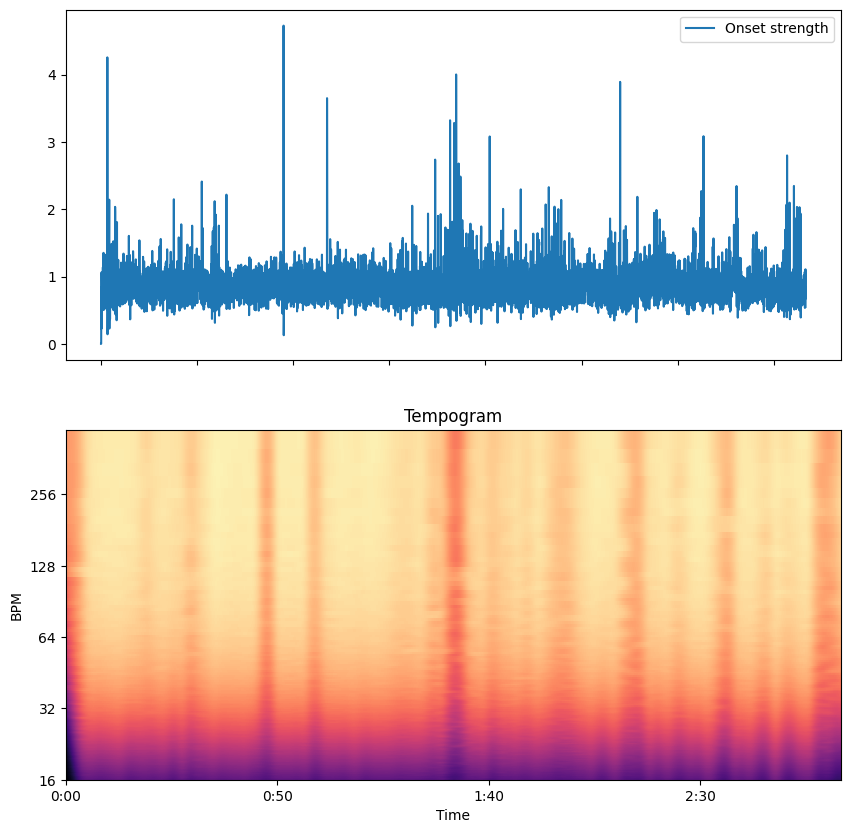

Matplotlib plt backend: module://matplotlib_inline.backend_inline


In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
times = librosa.times_like(oenv, sr=demo_sr, hop_length=512)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=demo_sr, hop_length=512,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].set(title='Tempogram')
plt.show()
print("Matplotlib plt backend: {}".format(plt.get_backend()))

The 4min audio is much longer then the other audio in the birdcall dataset, so the current set of SED parameters is not fit for this long audio, but it seem good for the the short audios. For the private test datatset, the audio are all about 10 minutes long, so there is probably one set of SED parameters for the private test.

# Composited data generator

In [28]:
num_process = 2
batch_size = 5
num_batch = math.ceil(len(audio_paths) / batch_size)
print("num_process: ", num_process)
print("num_batch", num_batch)
print("batch_size: ", batch_size)
audio_paths_batches = [audio_paths[x: x + batch_size] for x in range(0, len(audio_paths), batch_size)]
print("total number of audio file: ", len(audio_paths))
save_dir = "/kaggle/working/img_test/"
print("save to: ", save_dir)

num_process:  2
num_batch 3
batch_size:  5
total number of audio file:  15
save to:  /kaggle/working/img_test/


In [29]:
def loadSave(audio_paths_batches, i, save_dir):
    batch_size = len(audio_paths_batches)
    print("processing batch: {} for audio #{} to #{}".format(i, 0, batch_size ))
    image_audio_paths, image_ds, freqs_ds, times_ds = paths_to_image(audio_paths_batches,
                                                                     clip_length = 30,
                                                                     i=i,
                                                                     verbose = 0)
    print("batch_{} is processed".format(i))
    time.sleep(0.2)
    
    print("saving to batch_{} to [{}]".format(i,save_dir))
    saveImage(image_audio_paths = image_audio_paths, 
                     image_ds = image_ds, 
                     freqs_ds = freqs_ds,
                     times_ds = times_ds, 
                     save_dir = save_dir)
    print("saving batch_{} successfully".format(i))
    time.sleep(0.2)
    del image_ds, freqs_ds, times_ds
    


In [30]:
for i in range(num_batch):
    loadSave(audio_paths_batches[i], i, save_dir)

processing batch: 0 for audio #0 to #5
batch_0 (1/5): processing /kaggle/input/birdcall-check/test_audio/f77783ba4c6641bc918b034a18c23e53.mp3
batch_0 (2/5): processing /kaggle/input/birdcall-check/test_audio/99af324c881246949408c0b1ae54271f.mp3
batch_0 (3/5): processing /kaggle/input/birdcall-check/test_audio/41e6fe6504a34bf6846938ba78d13df1.mp3
batch_0 (4/5): processing /kaggle/input/birdcall-check/test_audio/899616723a32409c996f6f3441646c2a.mp3
batch_0 (5/5): processing /kaggle/input/birdcall-check/test_audio/9cc5d9646f344f1bbb52640a988fe902.mp3
Total sample: 165
batch_0 is processed
saving to batch_0 to [/kaggle/working/img_test/]
saving batch_0 successfully
processing batch: 1 for audio #0 to #5
batch_1 (1/5): processing /kaggle/input/birdcall-check/test_audio/6ab74e177aa149468a39ca10beed6222.mp3
batch_1 (2/5): processing /kaggle/input/birdcall-check/test_audio/856b194b097441958697c2bcd1f63982.mp3
batch_1 (3/5): processing /kaggle/input/birdcall-check/test_audio/07ab324c602e4afab65

# Prediction
- the audio will be evaluate in a a clip with  3/4 overlap for high density detection. 
- make prediction on all sampling using local maximum window with a fixed threhold to target on the high power sound,
- then assign the prediction to each signal 

In [31]:
# load dataset and preprocess images（the preprocess function in map  can preprocess all previous pictures)
def load_and_preprocess_image(img_path):
    # read pictures
    img_raw = tf.io.read_file(img_path)
    # decode pictures
    img_tensor = tf.image.decode_jpeg(img_raw, channels=1) # change channels to 3 result in 3-channel image
    # resize
#     img_tensor = tf.image.resize(img_tensor, [128, 128])
    #tf.cast() function is a type conversion function that converts the data format of x into dtype
    img_tensor = tf.cast(img_tensor, tf.float32)
    # normalization
    img_tensor = img_tensor / 255.0
    # flip left or right
#     img_tensor = tf.image.random_flip_left_right(img_tensor)
    return img_tensor


In [32]:
# define valid path
test_image_root = pathlib.Path(save_dir)
test_image_path = test_image_root.rglob('*.jpg')
test_image_path = [str(pathlib.Path(path)) for path in test_image_path]
print("total test images: ", len(test_image_path))

# get index of label and freq 
test_freq = [int(path.split('/')[-1].split('_')[1]) for path in test_image_path]
encode_test_freq = [freq_dict.get(freq) for freq in test_freq]

# convert to tensor and zip
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_path).map(load_and_preprocess_image)
test_freq_ds = tf.data.Dataset.from_tensor_slices(encode_test_freq)


total test images:  230


In [33]:
batch_size = 128
test_ds = tf.data.Dataset.zip(((test_image_ds, test_freq_ds), )).batch(batch_size)
iteration_test = iter(test_ds)

In [34]:
audio_id = [path.split('/')[-1].split('_')[0] for path in test_image_path]
raw_seconds = [int(path.split('/')[-1].split('_')[2].split('.')[0])/10 for path in test_image_path]
seconds = [5 * math.ceil(s/5) for s in raw_seconds]

result_pred_class = []
result_pred_class_prob = []
for i in range(0, len(test_image_path), batch_size):
    pred_prob = model.predict(iteration_test.get_next())
    pred_class_prob = np.amax(pred_prob, 1)
    pred_class_integer = np.argmax(pred_prob, 1)
    pred_class = [list(label_dict)[i] for i in pred_class_integer]
    result_pred_class += pred_class
    result_pred_class_prob += list(pred_class_prob)
    
result_raw = pd.DataFrame(data= {'audio_id': audio_id,
                             'raw_seconds': raw_seconds, 
                             'seconds': seconds, 
                             'freq': test_freq, 
                             'birds': result_pred_class,
                             'pred_class_prob': result_pred_class_prob}).sort_values(by = ['audio_id', 'raw_seconds'])

,audio_id,raw_seconds,seconds,freq,birds,pred_class_prob
191,07ab324c602e4afab65ddbcc746c31b5,2.2,5,284,aldfly,0.858805
37,07ab324c602e4afab65ddbcc746c31b5,2.4,5,275,aldfly,0.989658
70,6ab74e177aa149468a39ca10beed6222,25.8,30,267,saypho,0.850398
100,6ab74e177aa149468a39ca10beed6222,27.1,30,175,saypho,0.857590
193,6ab74e177aa149468a39ca10beed6222,30.2,35,175,saypho,0.931782
...,...,...,...,...,...,...
87,a56e20a518684688a9952add8a9d5213,17.7,20,227,aldfly,0.980576
62,cce64fffafed40f2b2f3d3413ec1c4c2,24.2,25,234,pygnut,0.896989
196,cce64fffafed40f2b2f3d3413ec1c4c2,24.6,25,199,astfly,0.883114
210,de62b37ebba749d2abf29d4a493ea5d4,6.4,10,212,astfly,0.986449


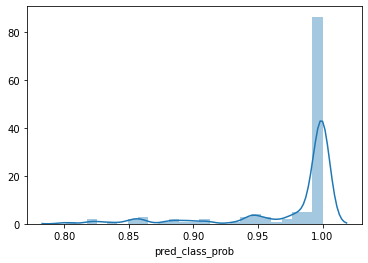

In [35]:
threshold = 0.8
result = result_raw[result_raw['pred_class_prob'] > threshold]
sns.distplot(result['pred_class_prob'])
result

##  Site 1 & 2
- each signal will be aggregate to the 5 seconds time frame,
- the final prediction are determined by the weighted probablity of each bird prediction within each 5s clip. hopefully this will combine the effect of count of signal and the confident of each signal  


In [36]:
def appandLabel(x):
    x = list(x)
    separator = ' '
    x = separator.join(x)
    return x

In [37]:
sub_test_12 = test_df[test_df.site.isin(['site_1', 'site_2'])]
sub_test_12 = sub_test_12.merge(result, on = ['audio_id','seconds'], how ='left')
sub_test_12 = sub_test_12[['row_id','birds','pred_class_prob']].groupby(['row_id','birds'])['pred_class_prob'].sum().reset_index()
sub_test_12 = sub_test_12[sub_test_12['pred_class_prob'] > 1]
sub_test_12 = sub_test_12[['row_id','birds']].drop_duplicates().groupby(['row_id'])['birds'].apply(appandLabel).reset_index()
sub_test_12.head(25)

,row_id,birds
0,site_1_6ab74e177aa149468a39ca10beed6222_30,saypho
1,site_1_99af324c881246949408c0b1ae54271f_15,pygnut
2,site_2_07ab324c602e4afab65ddbcc746c31b5_5,aldfly
3,site_2_8680a8dd845d40f296246dbed0d37394_15,pygnut
4,site_2_8680a8dd845d40f296246dbed0d37394_35,aldfly


## site 3
- sum pred_class_prob by group of 'row_id','birds'
- remove the sum prob less than 15

In [38]:
sub_test_3 = test_df[test_df.site.isin(['site_3'])]
sub_test_3 = sub_test_3[['row_id', 'audio_id']].merge(result[['audio_id','birds','pred_class_prob']], on=['audio_id'], how='left')
sub_test_3 = sub_test_3[['row_id','birds','pred_class_prob']].groupby(['row_id','birds'])['pred_class_prob'].sum().reset_index()
sub_test_3 = sub_test_3[sub_test_3['pred_class_prob'] > 15]
sub_test_3 = sub_test_3[['row_id','birds']].drop_duplicates().groupby(['row_id'])['birds'].apply(appandLabel).reset_index()
sub_test_3.head(25)

,row_id,birds
0,site_3_9cc5d9646f344f1bbb52640a988fe902,aldfly


## submission

In [39]:
try:
    shutil.rmtree(save_dir)
except:
    pass

In [40]:
sub = sub_test_12.append(sub_test_3)
sub = test_df.merge(sub, how='left')[['row_id','birds']]
sub['birds'] = sub['birds'].fillna('nocall')
sub.to_csv('submission.csv', index=False)
sub.iloc[random.sample(range(test_df.shape[0]),50),:]

,row_id,birds
45,site_2_940d546e5eb745c9a74bce3f35efa1f9_20,nocall
41,site_2_8680a8dd845d40f296246dbed0d37394_45,nocall
51,site_2_940d546e5eb745c9a74bce3f35efa1f9_50,nocall
60,site_2_07ab324c602e4afab65ddbcc746c31b5_25,nocall
7,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_15,nocall
4,site_1_41e6fe6504a34bf6846938ba78d13df1_25,nocall
35,site_2_8680a8dd845d40f296246dbed0d37394_15,pygnut
74,site_3_f77783ba4c6641bc918b034a18c23e53,nocall
66,site_2_899616723a32409c996f6f3441646c2a_30,nocall
6,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_10,nocall


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

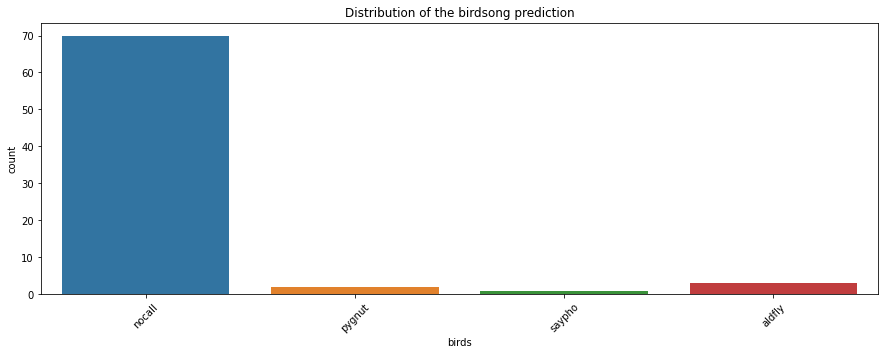

In [41]:
plt.figure(figsize=(15, 5))
sns.countplot(x="birds", data = sub)
plt.title("Distribution of the birdsong prediction")
plt.xticks(rotation=45)